In [1]:
# from google.colab import drive
# import gensim
# import keras
# from keras import metrics

In [2]:
# drive.mount('/content/drive')

In [3]:
# %cd "/content/drive/My Drive/1_processing/w2v_cnn"

In [4]:
import sys
!{sys.executable} -m pip install gensim

In [5]:
import sys
!{sys.executable} -m pip install keras

In [6]:
import sys
!{sys.executable} -m pip install tensorflow

In [7]:
import pandas as pd
import numpy as np
import pickle
import gensim
import keras
from keras import metrics

In [8]:
import sys
!{sys.executable} -m pip install spacy

In [9]:
import spacy 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [10]:
from tensorflow.python.keras.metrics import Metric

In [11]:
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D,MaxPooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.layers import Reshape, Flatten, Dropout, Concatenate,BatchNormalization
from keras.layers.core import Reshape
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.optimizers import Adam,SGD,Adadelta, Adagrad
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import regularizers
# from tensorflow.keras.callbacks import EarlyStopping
# tf.compat.v1.disable_eager_execution()

In [12]:
with open('mutated.pkl', 'rb') as input_file:
    mutated = pickle.load(input_file)   
print(mutated.columns)
mutated.shape

Index(['repo_count', 'task_name', 'method_description', 'mod_keys_found',
       'mod_values_found', 'key_module_text', 'value_module_text',
       'mod_keys_found_string', 'found_used_parameters', 'has_params',
       'third_ast', 'third_tokens', 'token_task_names', 'descr_one_string',
       'consistent', 'task_com', 'task_complete'],
      dtype='object')


(20792, 17)

In [13]:
with open('top10_list.pkl', 'rb') as input_file:
    top10_list = pickle.load(input_file)   
top10_list

['shell',
 'command',
 'set_fact',
 'template',
 'file',
 'gather_facts',
 'copy',
 'service',
 'debug',
 'fail']

In [14]:
mutated = mutated[mutated['mod_keys_found_string'] == 'set_fact']
mutated.shape

(2492, 17)

In [15]:
train_set, val_set, test_set = np.split(mutated.sample(frac=1), [int(.6*len(mutated)), int(.8*len(mutated))])

In [16]:
print(train_set.shape)
print(val_set.shape)
test_set.shape

(1495, 17)
(498, 17)


(499, 17)

In [17]:
# train_set = train_set.reset_index(drop=True)
# test_set = train_set.reset_index(drop=True)
# val_set = train_set.reset_index(drop=True)

In [18]:
from gensim.models import Word2Vec, KeyedVectors

<h4>Word2vec</h4>




In [19]:
tasks_sent_train = [row for row in train_set['task_complete']]

In [20]:
model_tasks3 = Word2Vec(tasks_sent_train, sg = 0, size=100, window=6, min_count=1, workers=4, iter= 1000)

<h4>CNN</h4>

In [21]:
def list_to_string(lst):

  one_string = ' '.join(lst)

  return one_string

In [22]:
train_set['task_complete_one_string'] = train_set['task_complete'].apply(lambda x: list_to_string(x))
test_set['task_complete_one_string'] = test_set['task_complete'].apply(lambda x: list_to_string(x))
val_set['task_complete_one_string'] = val_set['task_complete'].apply(lambda x: list_to_string(x))

In [23]:
# train_set['task_complete_one_string'][11548]

In [24]:
y_train = train_set['consistent'].astype(int)
print(y_train.value_counts(),y_train.shape)

y_test = test_set['consistent'].astype(int)
print(y_test.value_counts(),y_test.shape)

y_val = val_set['consistent'].astype(int)
print(y_val.value_counts(),y_val.shape)

0    767
1    728
Name: consistent, dtype: int64 (1495,)
1    259
0    240
Name: consistent, dtype: int64 (499,)
1    259
0    239
Name: consistent, dtype: int64 (498,)


In [25]:
test_set.shape

(499, 18)

In [26]:
word_vectors = model_tasks3.wv
type(word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [27]:
len(word_vectors.vocab)

5300

In [28]:
tokenizer_train = Tokenizer(lower=False) 
tokenizer_train.fit_on_texts(train_set['task_complete'])
print(tokenizer_train)

tokenizer_test = Tokenizer(lower=False) 
tokenizer_test.fit_on_texts(test_set['task_complete'])
print(tokenizer_test)

tokenizer_val = Tokenizer(lower=False) 
tokenizer_val.fit_on_texts(val_set['task_complete'])
tokenizer_val

In [29]:
list(tokenizer_train.word_index)[0:10]

['AnsibleTask',
 'TaskName',
 'TaskDescription',
 'set_fact',
 'when',
 'Set',
 'is',
 'set',
 'for',
 'True']

In [30]:
print("len(tokenizer) :",len(list(tokenizer_train.word_index)))

len(tokenizer) : 5300


In [31]:
tasks_train_tokens = tokenizer_train.texts_to_sequences(train_set['task_complete_one_string'])
tasks_test_tokens = tokenizer_test.texts_to_sequences(test_set['task_complete_one_string'])
tasks_val_tokens = tokenizer_val.texts_to_sequences(val_set['task_complete_one_string'])

In [32]:
# print(tasks_train_tokens[800])

In [33]:
num_tokens = [len(tokens) for tokens in tasks_train_tokens]
num_tokens = np.array(num_tokens)

In [34]:
len(num_tokens)

1495

In [35]:
np.max(num_tokens)

204

In [36]:
np.argmax(num_tokens)

810

In [37]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

57

In [38]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9719063545150501

In [39]:
tasks_train_pad = pad_sequences(tasks_train_tokens, maxlen=max_tokens,padding='post')
tasks_test_pad = pad_sequences(tasks_test_tokens, maxlen=max_tokens,padding='post')
tasks_val_pad = pad_sequences(tasks_val_tokens, maxlen=max_tokens,padding='post')

In [40]:
tasks_train_pad.shape[0]

1495

In [41]:
print("x_train_tokens :",tasks_train_tokens[0])
print("x_train_pad :",tasks_train_pad[0])

x_train_tokens : [1, 2, 8, 21, 51, 1485, 9, 87, 203, 1111, 3, 8, 11, 1111, 51, 449, 61, 196, 39, 1485, 141, 1349, 196, 39, 1485, 1744, 467, 5, 13, 1744, 467]
x_train_pad : [   1    2    8   21   51 1485    9   87  203 1111    3    8   11 1111
   51  449   61  196   39 1485  141 1349  196   39 1485 1744  467    5
   13 1744  467    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [42]:
print("x_train_pad.shape :",tasks_train_pad.shape)

x_train_pad.shape : (1495, 57)


In [43]:
idx = tokenizer_train.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [44]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [45]:
embedding_size = 100

In [46]:
num_words = len(list(tokenizer_train.word_index))+1
num_words

5301

In [47]:
embedding_matrix = np.random.uniform(-1, 1, (num_words, embedding_size))
for word, i in tokenizer_train.word_index.items():
    if i < num_words:
        embedding_vector = model_tasks3[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

/home/indika_kuma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [48]:
embedding_matrix.shape

(5301, 100)

In [49]:
embedding_matrix

array([[-0.80686065, -0.83229104,  0.11143421, ...,  0.72673538,
         0.01897481, -0.89228194],
       [-4.77425909, -2.10319877,  5.93406534, ..., -0.16304727,
        -0.63446128,  3.44453597],
       [-1.00487518, -3.47643542,  2.16983104, ..., -0.22994469,
        -2.31468153,  1.47853625],
       ...,
       [ 0.39414153,  0.45373723, -0.76490855, ..., -0.37420809,
         0.76646137, -0.70431584],
       [ 0.36735344,  0.32206404, -0.56260073, ..., -0.46176291,
         0.68290007, -0.49488196],
       [-0.02324706,  0.11718029, -0.40823644, ..., -0.53351951,
         0.12231456, -0.14461504]])

In [50]:
sequence_length = max_tokens
vocabulary_size = num_words
embedding_dim = embedding_size
filter_sizes = [3,4,5]
batch_size = 256
# num_filters = 512
# drop = 0.5

In [51]:
embedding_layer = Embedding(input_dim=num_words,output_dim=embedding_size,weights= [embedding_matrix],input_length=max_tokens, trainable=False,name='embedding_layer')
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
embedding

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


<tf.Tensor 'embedding_layer/embedding_lookup/Identity_1:0' shape=(None, 57, 100) dtype=float32>

In [52]:
sample_size = tasks_train_pad.shape
print(sample_size)
print(len(tasks_train_pad[0]))

(1495, 57)
57


In [53]:
tf.compat.v1.disable_eager_execution()

In [54]:
#CNN architecture


num_classes = 2

#Training params
# batch_size = 256 
num_epochs = 20

#Model parameters
num_filters = 64  
embed_dim = embedding_size 
weight_decay = 1e-4

print("training CNN ...")
model = Sequential()

#Model add word2vec embedding

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    weights= [embedding_matrix],
                    input_length=max_tokens,        
                    trainable=True,              #the layer is trained
                    name='embedding_layer'))
model.add(layers.Conv1D(filters = num_filters, kernel_size = max_tokens, activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.MaxPooling1D(2))
model.add(Dropout(0.25))

model.add(layers.Conv1D(filters = num_filters+num_filters, kernel_size = max_tokens, activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.GlobalMaxPooling1D())
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
# model.add(BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer = sgd,metrics=['accuracy'])
model.summary()


history = model.fit(tasks_train_pad, to_categorical(y_train), batch_size=batch_size, epochs=num_epochs, validation_data=(tasks_test_pad, to_categorical(y_test)),
                 shuffle=True, verbose=2)

training CNN ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 57, 100)           530100    
_________________________________________________________________
conv1d (Conv1D)              (None, 57, 64)            364864    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 128)           467072    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128

In [55]:
from matplotlib import pyplot

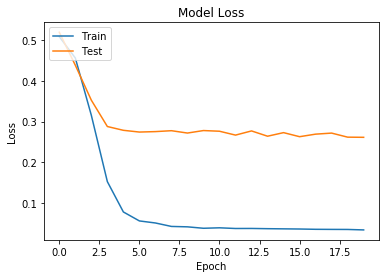

In [56]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.savefig('loss/loss_set_fact.jpg', dpi=600)
pyplot.show()

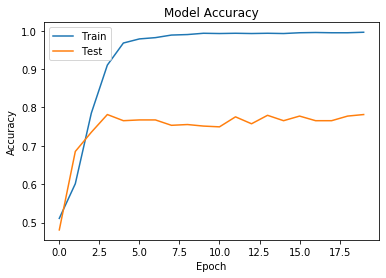

In [57]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Model Accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.savefig('accs/acc_set_fact.jpg', dpi=600)
pyplot.show()

In [58]:
score = model.evaluate(tasks_val_pad, to_categorical(y_val), verbose=0)

In [59]:
print('loss:', score[0])
print('Validation accuracy:', score[1])

loss: 0.2156041842028798
Validation accuracy: 0.8192771


In [60]:
y_pred=model.predict_classes(tasks_val_pad)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[214  25]
 [ 65 194]]


In [63]:
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]
tn= cm[0][0]
all_val = tp+fp+fn+tn

In [64]:
precision = round(tp/(tp+fp),2)
precision

0.89

In [65]:
recall = round(tp/(tp+fn), 2)
recall

0.75

In [66]:
f1_score = (2*precision*recall)/(precision+recall)
f1_score

0.8140243902439024

In [67]:
precision_neg = round(tn/(tn+fn),2)
precision_neg

0.77

In [68]:
recall_neg = round(tn/(tn+fp), 2)
recall_neg

0.9

In [69]:
f1_score = (2*precision_neg*recall_neg)/(precision_neg+recall_neg)
f1_score

0.8299401197604791

In [70]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from matplotlib import pyplot

In [71]:
ns_probs = [0 for _ in range(len(y_val))]

In [72]:
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, y_pred)
mcc      = matthews_corrcoef (y_val, y_pred)

In [73]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Our model: ROC AUC=%.3f' % (lr_auc))
print('Our model: MCC=%.3f' % (mcc))

No Skill: ROC AUC=0.500
Our model: ROC AUC=0.822
Our model: MCC=0.649


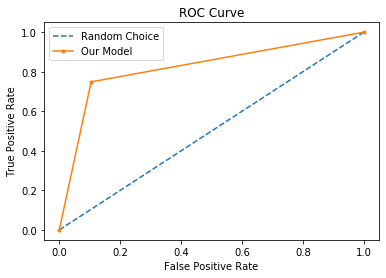

In [74]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)

lr_fpr, lr_tpr, _ = roc_curve(y_val, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Choice')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Our Model')
pyplot.title('ROC Curve')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.savefig('rocs/roc_set_fact.jpg', dpi=600)
# show the plot
pyplot.show()